# End-to-End Visual Wake Words (VWW) Project for Edge AI

## 1. Project Overview
**Visual Wake Words (VWW)** represents a class of tiny, low-power computer vision models designed to detect the presence of a specific object (usually a person) to "wake up" a larger system. Think of it as the visual equivalent of "Hey Siri".

**Real-World Use Cases include:**
* **Smart Doorbells:** Only start recording/streaming when a human is at the door.
* **Smart Office:** Turn on lights/HVAC only when a room is occupied.
* **Safety Monitors:** Detect if a person enters a hazardous zone.

### 1.1 Why Edge AI? (Advantages over Cloud)
Traditionally, deep learning runs on powerful cloud servers. However, for "always-on" applications, moving inference to the **Edge (On-Device)** offers critical advantages:

1.  **Privacy:** Images are processed locally and immediately discarded. No personal video feeds are streamed to the cloud, mitigating privacy concerns.
2.  **Latency:** Inference happens in milliseconds without network round-trip delays. This is crucial for real-time safety triggers.
3.  **Bandwidth & Power:** Streaming 24/7 video drains batteries and consumes massive data. A VWW model consumes milliwatts and sends only a simple "wake up" signal.
4.  **Reliability:** The system functions correctly even without an internet connection.

### 1.2 Key Challenges in Edge AI(Tiny Deep Learning)
Deploying Deep Learning models on Microcontrollers (MCUs) is significantly harder than on GPUs due to the **"Iron Triangle" of constraints**:

*   **Extreme Memory Scarcity:** 
    *   Cloud GPUs have 24GB+ VRAM. 
    *   MCUs (e.g., ESP32, Arduino Nano) often have **<512KB SRAM** and **<2MB Flash**. 
    *   *Challenge:* The model must be tiny enough to fit in Flash and its runtime variables (activations) must fit in SRAM.
*   **Limited Compute Power:** 
    *   MCUs run at low clock speeds (e.g., 80-240 MHz) with no hardware acceleration.
    *   *Challenge:* We must minimize **MACs (Multiply-Accumulate Operations)** to ensure the inference finishes quickly (low latency).
*   **Quantization Sensitivity:**
    *   To save space and speed up math, we convert 32-bit floating-point numbers to **8-bit integers (Int8)**.
    *   *Challenge:* This loss of precision can severely degrade accuracy if the model architecture is not robust.



### 1.3 **Project Goals & Phased Approach**
This project aims to not just train a single model, but to systematically evaluate and select the optimal architecture for a specific hardware constraint. We adopt a two-phase approach:

**Phase 1: Model Design & Proxy Evaluation (Current Scope)**
*   **Environment:** PC / Cloud (Google Colab / Local Jupyter).
*   **Objective:** Train candidate models, perform Int8 quantization, and evaluate using "Proxy Metrics".
*   **Key Metrics:** 
    *   **Accuracy / F1-Score / AUC:** To ensure detection reliability.
    *   **Model Size (Flash Usage):** To ensure it fits on the chip.
    *   **MACs (Multiply-Accumulate Operations):** A hardware-agnostic proxy for Latency and Power consumption.
    *   **Peak RAM Estimation:** To ensure it fits in SRAM.

**Phase 2: Hardware-in-the-Loop Deployment and evaluation(Future Work)**
*   **Environment:** Physical MCU (e.g., ESP32-S3, Arduino Nano 33 BLE).
*   **Objective:** Deploy the best candidates from Phase 1 and measure real-world performance.
*   **Key Metrics:** 
    *   **Real Latency (ms):** Measured on-device.
    *   **Real Power Consumption (mW):** Measured via power profiler.
    *   **Real MACs**
    *   **Real Peak RAM consumption**


**Workflow in phase 1:**
1.  **Data Engineering:** Acquire INRIA Person Dataset and perform EDA.
2.  **Modeling:** Train MobileNetV2, MobileNetV3, and SimpleCNN.
3.  **Quantization:** Convert to TFLite Int8.
4.  **Evaluation:** Compare models using Accuracy, F1, AUC, and MACs.

---
## 2. Environment Setup
We use TensorFlow 2.x. Either CPU, TPU or GPU is suitable for this job.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
import tarfile
import urllib.request
import time
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import pandas as pd

# Check Environment
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Define Global Parameters
IMG_SIZE = 96
BATCH_SIZE = 32
dataset_dir = pathlib.Path("vww_dataset")

TensorFlow Version: 2.19.0
GPU Available: True



---
## 3. Data Engineering
### Dataset Selection: INRIA Person Dataset
For this project, we selected the **INRIA Person Dataset**, a benchmark dataset originally designed for pedestrian detection.

#### **Why this dataset?**
1.  **Real-World Complexity:** Unlike simple datasets (like MNIST or Fashion-MNIST), INRIA features people in diverse environments (cities, mountains, beaches) with varying lighting, poses, and occlusions. This forces the model to learn robust features.
2.  **Relative Balanced Classes:** It provides a clear separation between "Positive" (images containing upright people) and "Negative" (images of scenery, buildings, cars, etc. with **no** people).
3.  **Manageable Size:** At ~970MB, it is large enough to train a generalized model but small enough to download and process quickly in a Colab environment, unlike the 20GB+ COCO dataset often used for VWW.

#### **Dataset Specs**
*   **Source:** Dalal, N., & Triggs, B. (2005). *Histograms of oriented gradients for human detection*. CVPR.
*   **Content:**
    *   **Positive:** Images of standing people (pedestrians).
    *   **Negative:** Diverse background images (urban, nature, indoor) without people.
*   **Original Format:** Variable resolution images. We will resize them to 96x96.

### 3.1 Download & Extraction
We download the dataset from a stable archive mirror.

In [2]:
# Define paths
dataset_url = "https://web.archive.org/web/20190301110434/ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar"
archive_path = "INRIAPerson.tar"
extract_path = "INRIAPerson_Raw"

# 1. Download
if not os.path.exists(archive_path) and not os.path.exists(extract_path):
    print("Downloading INRIA Person Dataset (this may take a few minutes)...")
    # Using wget with no-check-certificate for stability
    if os.system(f"wget --no-check-certificate {dataset_url} -O {archive_path}") != 0:
        print("wget failed, trying urllib...")
        try:
            urllib.request.urlretrieve(dataset_url, archive_path)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
else:
    print("Archive already exists or extracted.")

# 2. Extract
if not os.path.exists(extract_path):
    if os.path.exists(archive_path):
        print("Extracting...")
        try:
            with tarfile.open(archive_path) as tar:
                tar.extractall(extract_path)
            print("Extraction complete.")
        except tarfile.ReadError:
            print("Error: Corrupted archive.")
    else:
        print("Archive not found.")
else:
    print("Data already extracted.")

Extracting...
Extracting...


/tmp/ipython-input-2914048355.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_path)


Extraction complete.


### 3.2 Data Restructuring
We reorganize the raw data into the standard Keras directory format:
*   `train/person` & `train/not_person`
*   `validation/person` & `validation/not_person`

In [3]:
def organize_dataset(source_root, dest_root):
    if dest_root.exists():
        print(f"Destination {dest_root} already exists. Skipping organization.")
        return

    print(f"Organizing data from {source_root} to {dest_root}...")
    inria_root = pathlib.Path(source_root) / "INRIAPerson"
    
    splits = {'train': 'Train', 'validation': 'Test'}
    labels = {'person': 'pos', 'not_person': 'neg'}

    for split_name, inria_split in splits.items():
        for label_name, inria_label in labels.items():
            src_dir = inria_root / inria_split / inria_label
            dest_dir = dest_root / split_name / label_name
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            files = list(src_dir.glob('*.png')) + list(src_dir.glob('*.jpg'))
            for f in files:
                shutil.copy2(f, dest_dir / f.name)
                
    print("Data organization complete.")

organize_dataset(extract_path, dataset_dir)

Organizing data from INRIAPerson_Raw to vww_dataset...
Data organization complete.
Data organization complete.


### 3.3 Exploratory Data Analysis (EDA)
Before preprocessing, it is crucial to understand our data distribution. We will check for class imbalance and visualize random samples to understand the difficulty of the task.

#### 3.3.1 Class Distribution Analysis

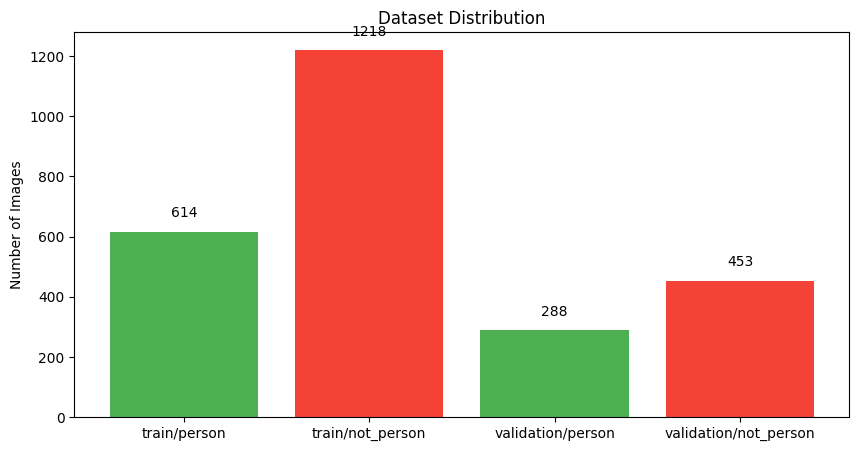

In [4]:
# 1. Class Distribution Analysis
def plot_class_distribution(data_dir):
    data_dir = pathlib.Path(data_dir)
    splits = ['train', 'validation']
    labels = ['person', 'not_person']
    
    stats = []
    for split in splits:
        for label in labels:
            count = len(list((data_dir / split / label).glob('*')))
            stats.append({'Split': split, 'Label': label, 'Count': count})
            
    # Plot
    plt.figure(figsize=(10, 5))
    x = np.arange(len(stats))
    counts = [s['Count'] for s in stats]
    names = [f"{s['Split']}/{s['Label']}" for s in stats]
    colors = ['#4CAF50' if 'person' in n and 'not_person' not in n else '#F44336' for n in names]
    
    plt.bar(x, counts, color=colors)
    plt.xticks(x, names)
    plt.title('Dataset Distribution')
    plt.ylabel('Number of Images')
    for i, v in enumerate(counts):
        plt.text(i, v + 50, str(v), ha='center')
    plt.show()

plot_class_distribution(dataset_dir)

#### 3.3.2 Image Quality & Dimensions Analysis

Analyzing image dimensions (Sample: 500)...


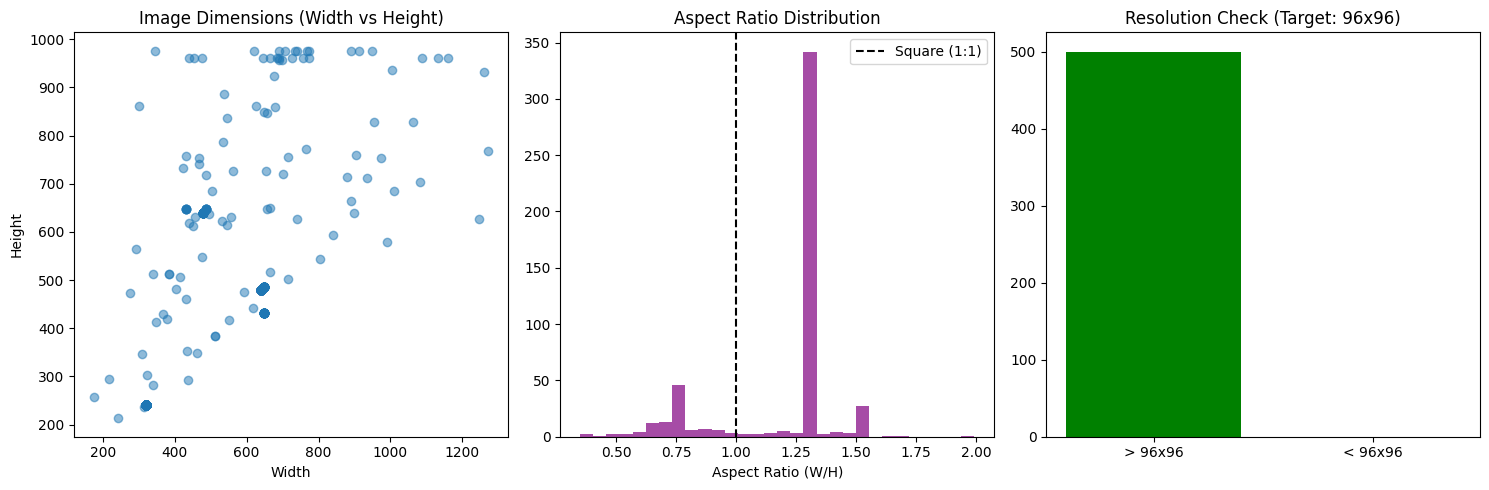

Analysis Summary:
  - Mean Resolution: 513x449
  - Images smaller than target (96x96): 0 (0.0%)
  - Aspect Ratio skew: Most images are Landscape.
  - Recommendation: Direct resize is acceptable.


In [5]:

# 2. Image Quality & Dimensions Analysis
def analyze_image_dimensions(data_dir):
    data_dir = pathlib.Path(data_dir)
    # Sample 500 images to speed up analysis
    all_files = list(data_dir.glob('*/*/*'))
    if len(all_files) > 500:
        sampled_files = np.random.choice(all_files, 500, replace=False)
    else:
        sampled_files = all_files
        
    widths = []
    heights = []
    aspect_ratios = []
    
    print("Analyzing image dimensions (Sample: 500)...")
    for f in sampled_files:
        try:
            img = tf.io.decode_image(tf.io.read_file(str(f)))
            h, w, _ = img.shape
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)
        except:
            pass # Skip corrupted
            
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Dimensions (Width vs Height)')
    plt.xlabel('Width')
    plt.ylabel('Height')
    
    plt.subplot(1, 3, 2)
    plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (W/H)')
    plt.axvline(1.0, color='k', linestyle='--', label='Square (1:1)')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    # Check for extremely small images that might lose info when resized
    small_imgs = sum(1 for w, h in zip(widths, heights) if w < 96 or h < 96)
    plt.bar(['> 96x96', '< 96x96'], [len(widths)-small_imgs, small_imgs], color=['green', 'orange'])
    plt.title('Resolution Check (Target: 96x96)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Analysis Summary:")
    print(f"  - Mean Resolution: {np.mean(widths):.0f}x{np.mean(heights):.0f}")
    print(f"  - Images smaller than target (96x96): {small_imgs} ({(small_imgs/len(widths))*100:.1f}%)")
    print(f"  - Aspect Ratio skew: Most images are {'Portrait' if np.mean(aspect_ratios) < 1 else 'Landscape'}.")
    print(f"  - Recommendation: {'Resize with padding' if np.std(aspect_ratios) > 0.5 else 'Direct resize'} is acceptable.")

analyze_image_dimensions(dataset_dir)

#### 3.3.3 Sample Visualization

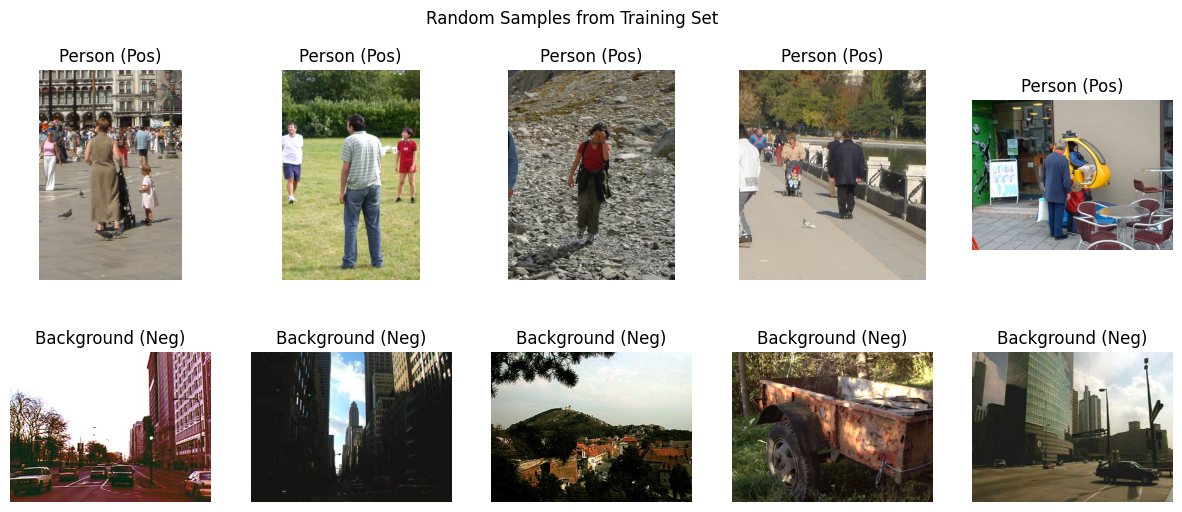

In [6]:



# 3. Sample Visualization
def visualize_samples(data_dir, num_samples=5):
    data_dir = pathlib.Path(data_dir)
    plt.figure(figsize=(15, 6))
    
    # Positive Samples
    pos_files = list((data_dir / 'train' / 'person').glob('*'))
    neg_files = list((data_dir / 'train' / 'not_person').glob('*'))
    
    for i in range(num_samples):
        # Pos
        plt.subplot(2, num_samples, i + 1)
        if pos_files:
            img = plt.imread(str(np.random.choice(pos_files)))
            plt.imshow(img)
        plt.title("Person (Pos)")
        plt.axis('off')
        
        # Neg
        plt.subplot(2, num_samples, i + 1 + num_samples)
        if neg_files:
            img = plt.imread(str(np.random.choice(neg_files)))
            plt.imshow(img)
        plt.title("Background (Neg)")
        plt.axis('off')
    plt.suptitle(f"Random Samples from Training Set")
    plt.show()

visualize_samples(dataset_dir)

### 3.4 Preprocessing Pipeline
*   **Resize:** 96x96 (TinyML Standard Resolution).
*   **Augmentation:** Random flips and brightness adjustments to improve robustness against real-world variations.
*   **Normalization Strategy:** 
    *   We do **NOT** normalize in the pipeline. The pipeline outputs images in `[0, 255]`.
    *   Normalization is handled **inside the model** via a `Rescaling` layer. This allows us to swap models easily (e.g., MobileNetV2 needs `[-1, 1]`, V3 handles it internally) without changing the data pipeline.

In [7]:
# Load Datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Preprocessing Functions
# NOTE: We removed normalization here to handle it inside the models.
# This allows us to use models that expect different ranges (e.g., V3 expects [0,255], V2 expects [-1,1]).
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Build Pipelines
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

print("✅ Data Pipeline Ready (Output range: [0, 255]).")

Found 1832 files belonging to 2 classes.
Found 741 files belonging to 2 classes.
Found 741 files belonging to 2 classes.
✅ Data Pipeline Ready (Output range: [0, 255]).
✅ Data Pipeline Ready (Output range: [0, 255]).


---

## 4. Model Development

Choosing the right architecture for Edge AI is a critical trade-off between **Accuracy**, **Latency**, **Model Size** and **Power consumption**. We evaluated three primary candidates and considered several others.

**1. MobileNetV2**
*   **Why we chose it:** MobileNetV2 is the "Goldilocks" of TinyML. It introduces *Inverted Residuals* and *Linear Bottlenecks*, which are highly efficient.
*   **Configuration:** `alpha=0.35`. This width multiplier reduces the number of filters by ~65%, drastically shrinking the model size to fit within our <1MB constraint while maintaining ~94% accuracy.
*   **Pros:** Mature support in TFLite Micro, excellent accuracy-to-size ratio, easy to fine-tune.

**2. MobileNetV3-Small**
*   **Overview:** The successor to V2, designed specifically for mobile phones using Neural Architecture Search (NAS).
*   **Configuration:** We use `minimalistic=True`. This replaces advanced activation functions like `HardSwish` with standard `ReLU`.
*   **Why?** `HardSwish` is computationally expensive on simple MCUs and can cause issues with Int8 quantization simulation on PCs (XNNPACK bugs). Using the "minimalistic" version ensures better compatibility and efficiency for TinyML.

**3. Simple CNN (Baseline)**
*   **Overview:** A custom 3-layer Convolutional Neural Network.
*   **Why included?** To establish a baseline. It proves that "deep learning" is actually necessary. A simple CNN often fails to capture the complex textures and shapes of "people in the wild," leading to poor generalization.

**Other Potential Candidates**
*   **SqueezeNet:** An older architecture that pioneered small model sizes but relies on complex connections that can be harder to quantize effectively.
*   **EfficientNet-Lite:** A powerful family of models, but even the smallest (Lite0) is often too heavy (computationally) for low-power MCUs like the ESP32 compared to MobileNetV2-0.35.
*   **MCUNet:** A cutting-edge "TinyNAS" solution that designs the model *and* the inference engine together. While superior, it requires a complex specialized toolchain (TinyEngine) rather than standard TFLite.


In [8]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

# --- Helper 1: Calculate MACs (Multiply-Accumulate Operations) ---
def get_flops(model):
    try:
        # Convert Keras model to Frozen Graph for profiling
        full_model = tf.function(lambda x: model(x))
        concrete_func = full_model.get_concrete_function(
            tf.TensorSpec([1, 96, 96, 3], model.inputs[0].dtype))
        frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

        with tf.Graph().as_default() as graph:
            tf.graph_util.import_graph_def(graph_def, name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            
            # Suppress heavy output
            flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops
    except Exception as e:
        print(f"  [Warning] Could not calculate FLOPs: {e}")
        return 0

# --- Helper 2: Estimate Peak RAM (Arena Size) ---
def estimate_peak_ram(model, element_size=4):
    """
    Estimates Peak RAM based on the largest activation layer.
    element_size: 4 for Float32, 1 for Int8.
    """
    max_mem_bytes = 0
    
    for layer in model.layers:
        try:
            # Calculate Input Size
            input_shape = layer.input_shape
            if isinstance(input_shape, list): 
                in_bytes = sum([np.prod(s[1:]) for s in input_shape if s is not None])
            else:
                in_bytes = np.prod(input_shape[1:])
                
            # Calculate Output Size
            output_shape = layer.output_shape
            if isinstance(output_shape, list):
                out_bytes = sum([np.prod(s[1:]) for s in output_shape if s is not None])
            else:
                out_bytes = np.prod(output_shape[1:])
            
            # Total memory active during this layer's operation
            current_layer_mem = (in_bytes + out_bytes) * element_size
            
            if current_layer_mem > max_mem_bytes:
                max_mem_bytes = current_layer_mem
        except:
            continue
            
    return max_mem_bytes / 1024 # Convert to KB

# 1. MobileNetV2 (Selected)
def create_mobilenet_v2():
    # MobileNetV2 expects inputs in [-1, 1]
    # We add a Rescaling layer to map [0, 255] -> [-1, 1]
    # This ensures our single preprocessing pipeline (outputting [0, 255]) works for all models.
    base = tf.keras.applications.MobileNetV2(
        input_shape=(96, 96, 3), 
        include_top=False, 
        alpha=0.35, 
        weights='imagenet'
    )
    base.trainable = False # Freeze for transfer learning
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(96, 96, 3)),
        tf.keras.layers.Rescaling(1./127.5, offset=-1),
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# 2. MobileNetV3-Small (Comparison)
def create_mobilenet_v3():
    # MobileNetV3 expects inputs in [0, 255] (handled internally by its own Rescaling layer)
    # We use minimalistic=True to replace HardSwish with ReLU.
    # This improves compatibility with TFLite Int8 quantization on PC simulators (XNNPACK)
    # and is often preferred for very low-power MCUs.
    base = tf.keras.applications.MobileNetV3Small(
        input_shape=(96, 96, 3), 
        include_top=False, 
        weights='imagenet',
        minimalistic=True 
    )
    base.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(96, 96, 3)),
        # No Rescaling needed for V3 (it has it built-in)
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# 3. Simple CNN (Baseline)
def create_simple_cnn():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(96, 96, 3)),
        tf.keras.layers.Rescaling(1./127.5, offset=-1), # Normalize to [-1, 1]
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

print("✅ Model definitions ready.")

✅ Model definitions ready.


In [9]:
# Define the dictionary of models to train
# We use the functions defined in the previous cell
models_to_train = {
    "MobileNetV2": create_mobilenet_v2(),
    "MobileNetV3": create_mobilenet_v3(),
    "SimpleCNN": create_simple_cnn()
}

# Compile all models
for name, model in models_to_train.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(f"✅ {name} compiled.")

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


2128592/2128592 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
2128592/2128592 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
✅ MobileNetV2 compiled.
✅ MobileNetV3 compiled.
✅ SimpleCNN compiled.
✅ MobileNetV2 compiled.
✅ MobileNetV3 compiled.
✅ SimpleCNN compiled.


### 4.1 Training
We train for 10 epochs with `EarlyStopping` and `ModelCheckpoint` to save the best weights.

In [10]:
EPOCHS = 10
histories = {}
all_results = [] # Global list to store all metrics (Float & Int8)

# Helper to evaluate Keras model (Float32)
def evaluate_keras_model(model, dataset):
    y_true = []
    y_pred = []
    for img, label in dataset:
        pred = model.predict(img, verbose=0)
        y_pred.extend((pred > 0.5).astype(int).flatten())
        y_true.extend(label.numpy().flatten())
    
    f1 = f1_score(y_true, y_pred)
    return f1

print(f"Starting comparison training for {len(models_to_train)} models...")

for name, model in models_to_train.items():
    print(f"\n{'='*20} Training {name} {'='*20}")
    
    # Callbacks (Unique filename for each model)
    checkpoint_path = f'best_model_{name}.keras'
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
    
    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    duration = time.time() - start_time
    
    # --- 1. Calculate Float32 Metrics ---
    # Load best weights
    model.load_weights(checkpoint_path)
    
    # Size
    model.save(f"temp_{name}.keras")
    size_kb = os.path.getsize(f"temp_{name}.keras") / 1024
    os.remove(f"temp_{name}.keras")
    
    # MACs
    flops = get_flops(model)
    macs_m = (flops / 2) / 1e6
    
    # RAM
    ram_kb = estimate_peak_ram(model, element_size=4) # Float32 = 4 bytes
    
    # F1 Score
    f1 = evaluate_keras_model(model, val_ds)
    
    # Store results
    histories[name] = {
        'history': history.history,
        'duration': duration,
        'best_val_acc': max(history.history['val_accuracy']),
        'model_path': checkpoint_path
    }
    
    all_results.append({
        'Model': name,
        'Type': 'Float32',
        'F1 Score': f1,
        'Size (KB)': size_kb,
        'MACs (M)': macs_m,
        'Peak RAM (KB)': ram_kb
    })
    
    print(f"  -> Float32 Metrics: F1={f1:.2f}, Size={size_kb:.0f}KB, MACs={macs_m:.1f}M, RAM={ram_kb:.1f}KB")

Starting comparison training for 3 models...

==================== Training MobileNetV2 ====================
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 476ms/step - accuracy: 0.6754 - loss: 0.5812 - val_accuracy: 0.9339 - val_loss: 0.1802
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 476ms/step - accuracy: 0.6754 - loss: 0.5812 - val_accuracy: 0.9339 - val_loss: 0.1802
Epoch 2/10
15/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9532 - loss: 0.1718Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9490 - loss: 0.1577 - val_accuracy: 0.9460 - val_loss: 0.1500
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9490 - loss: 0.1577 - val_accuracy: 0.9460 - val_loss: 0.1500
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9574 - loss: 0.1202 - val_accuracy: 0.9474 - val_loss: 0.1394
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9574 - loss: 0.1202 - val_accuracy: 0.9474 - val_loss: 0.1394
Epoch 4/10
24/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy:

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


  -> Float32 Metrics: F1=0.94, Size=2191KB, MACs=11.2M, RAM=153.0KB

==================== Training MobileNetV3 ====================
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 385ms/step - accuracy: 0.6810 - loss: 0.6885 - val_accuracy: 0.8623 - val_loss: 0.3171
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 385ms/step - accuracy: 0.6810 - loss: 0.6885 - val_accuracy: 0.8623 - val_loss: 0.3171
Epoch 2/10
22/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8783 - loss: 0.3139Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.8736 - loss: 0.3117 - val_accuracy: 0.8893 - val_loss: 0.2619
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.8736 - loss: 0.3117 - val_accuracy: 0.8893 - val_loss: 0.2619
Epoch 3/10
19/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9147 - loss: 0.2381Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9142 - loss: 0.2311 - val_accuracy: 0.9069 - val_loss: 0.2326
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9142 - loss: 0.2311 - val

### 4.2 Training Visualization
We visualize the training history to diagnose model behavior:
1.  **Accuracy/Loss Curves:** Check for overfitting (large gap between train/val) and convergence speed.
2.  **Size vs. Accuracy Trade-off:** A scatter plot to visualize the "cost" (size) of "performance" (accuracy). Ideally, we want models in the top-left corner (High Accuracy, Small Size).

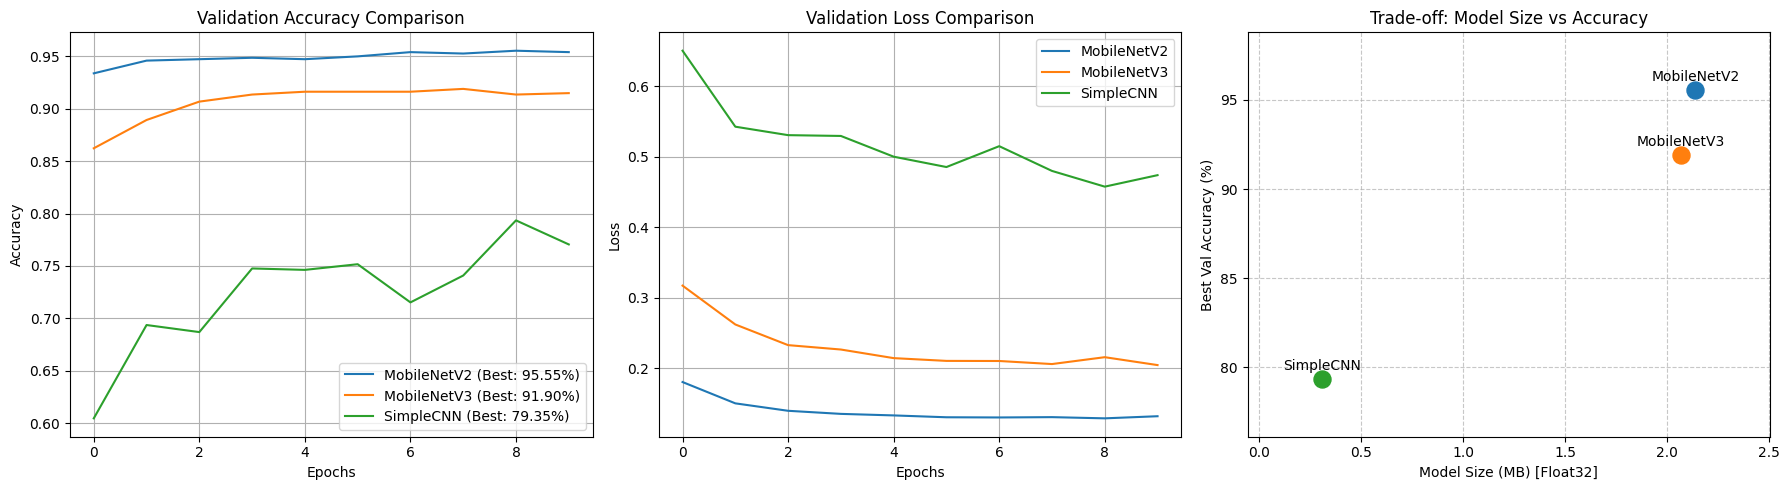

In [11]:
# --- Visualization of Comparison ---
plt.figure(figsize=(18, 5))

# 1. Accuracy Plot (Learning Curves)
plt.subplot(1, 3, 1)
for name, data in histories.items():
    plt.plot(data['history']['val_accuracy'], label=f"{name} (Best: {data['best_val_acc']:.2%})")
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Loss Plot
plt.subplot(1, 3, 2)
for name, data in histories.items():
    plt.plot(data['history']['val_loss'], label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Size vs Accuracy Scatter Plot (Trade-off)
plt.subplot(1, 3, 3)
names = list(histories.keys())
accs = [histories[n]['best_val_acc'] * 100 for n in names] # %

# FIX: Get size from all_results (which stores it in KB) and convert to MB
sizes = []
for n in names:
    # Find the Float32 result for this model in all_results
    res = next((r for r in all_results if r['Model'] == n and r['Type'] == 'Float32'), None)
    if res:
        sizes.append(res['Size (KB)'] / 1024) # KB -> MB
    else:
        sizes.append(0)

# Scatter plot
for i, name in enumerate(names):
    plt.scatter(sizes[i], accs[i], s=150, label=name)
    plt.text(sizes[i], accs[i] + 0.5, f"{name}", ha='center')

plt.title('Trade-off: Model Size vs Accuracy')
plt.xlabel('Model Size (MB) [Float32]')
plt.ylabel('Best Val Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
# Add some padding to margins
plt.margins(0.2)

plt.tight_layout()
plt.show()

## 5. Quantization & TFLite Conversion
This is the most critical step for Edge AI. We convert the Float32 Keras model into an **Int8 Quantized TFLite model**.

### Why Int8?
1.  **Size:** Reduces model size by 4x (32-bit -> 8-bit).
2.  **Speed:** MCUs can execute integer operations much faster than floating-point.
3.  **Compatibility:** Many DSPs and NPUs only support integer math.

### Representative Dataset
To quantize accurately, the converter needs to observe a small set of real images to estimate the dynamic range (Min/Max) of activations.

Starting Quantization...
Quantizing MobileNetV2...
Saved artifact at '/tmp/tmplcgp5qai'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133653561637968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939185744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939187472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133653561630480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133653561635856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939182288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939192080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939189200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939182864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133652939191120: TensorSpec(shape=

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


  -> Saved vww_MobileNetV2_int8.tflite (603.21 KB)
Quantizing MobileNetV3...
Saved artifact at '/tmp/tmp1j9hunmn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133650811943056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650811944784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650811943824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650811944592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650811944016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650810487056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650810488208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650810488016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650810487632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13365081

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


  -> Saved vww_MobileNetV3_int8.tflite (598.01 KB)
Quantizing SimpleCNN...
Saved artifact at '/tmp/tmpd8cvu4e6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133650854688528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854689680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854690064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854689872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854686224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854686032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854688912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133650854686416: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmpd8cvu4e6'. The following endpoints are available:

* En

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


  -> Saved vww_SimpleCNN_int8.tflite (30.55 KB)


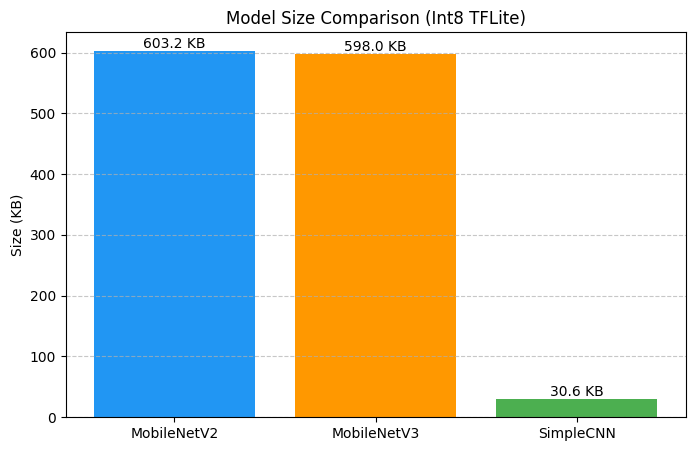

In [12]:
# Representative Dataset Generator (Shared for all models)
def representative_data_gen():
    for input_value, _ in train_ds.unbatch().batch(1).take(100):
        yield [input_value]

quantized_models = {}

print("Starting Quantization...")
for name, data in histories.items():
    print(f"Quantizing {name}...")
    
    # Load the best float model saved during training
    float_model = tf.keras.models.load_model(data['model_path'])
    
    # Converter Setup
    converter = tf.lite.TFLiteConverter.from_keras_model(float_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    tflite_model = converter.convert()
    
    # Save
    tflite_filename = f'vww_{name}_int8.tflite'
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)
        
    size_kb = len(tflite_model) / 1024
    quantized_models[name] = {
        'path': tflite_filename,
        'size_kb': size_kb
    }
    print(f"  -> Saved {tflite_filename} ({size_kb:.2f} KB)")

# --- Visual Comparison of Model Sizes ---
names = list(quantized_models.keys())
sizes = [quantized_models[n]['size_kb'] for n in names]

plt.figure(figsize=(8, 5))
bars = plt.bar(names, sizes, color=['#2196F3', '#FF9800', '#4CAF50'])
plt.title('Model Size Comparison (Int8 TFLite)')
plt.ylabel('Size (KB)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f} KB',
             ha='center', va='bottom')
plt.show()

## 6. Evaluation & Simulation
We verify the quantized model using the `tf.lite.Interpreter`. 

**Why Simulation?**
We cannot run the `.tflite` model directly in Keras. The Interpreter acts as a virtual MCU on our PC, allowing us to:
1.  Check if **Int8 quantization** caused a significant drop in accuracy.
2.  Verify the input/output tensor shapes match our expectations.
3.  Estimate inference## 6. Evaluation & Simulation
We verify the quantized model using the `tf.lite.Interpreter`. 


Evaluating Quantized Models...
  Evaluating vww_MobileNetV2_int8.tflite...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  -> MobileNetV2 (Int8): F1=0.93, Size=603KB, RAM=38.2KB
  Evaluating vww_MobileNetV3_int8.tflite...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


  -> MobileNetV3 (Int8): F1=0.83, Size=598KB, RAM=32.1KB
  Evaluating vww_SimpleCNN_int8.tflite...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  -> SimpleCNN (Int8): F1=0.73, Size=31KB, RAM=0.0KB

   FINAL EVALUATION REPORT
| Model       | Type    |   F1 Score |   Size (KB) |   MACs (M) |   Peak RAM (KB) |
|:------------|:--------|-----------:|------------:|-----------:|----------------:|
| MobileNetV2 | Float32 |       0.94 |     2191.37 |      11.24 |          153.00 |
| MobileNetV3 | Float32 |       0.90 |     2117.46 |       9.62 |          128.25 |
| SimpleCNN   | Float32 |       0.74 |      315.97 |      25.50 |            0.00 |
| MobileNetV2 | Int8    |       0.93 |      603.21 |      11.24 |           38.25 |
| MobileNetV3 | Int8    |       0.83 |      598.01 |       9.62 |           32.06 |
| SimpleCNN   | Int8    |       0.73 |       30.55 |      25.50 |            0.00 |

   VISUALIZATION: METRIC COMPARISON


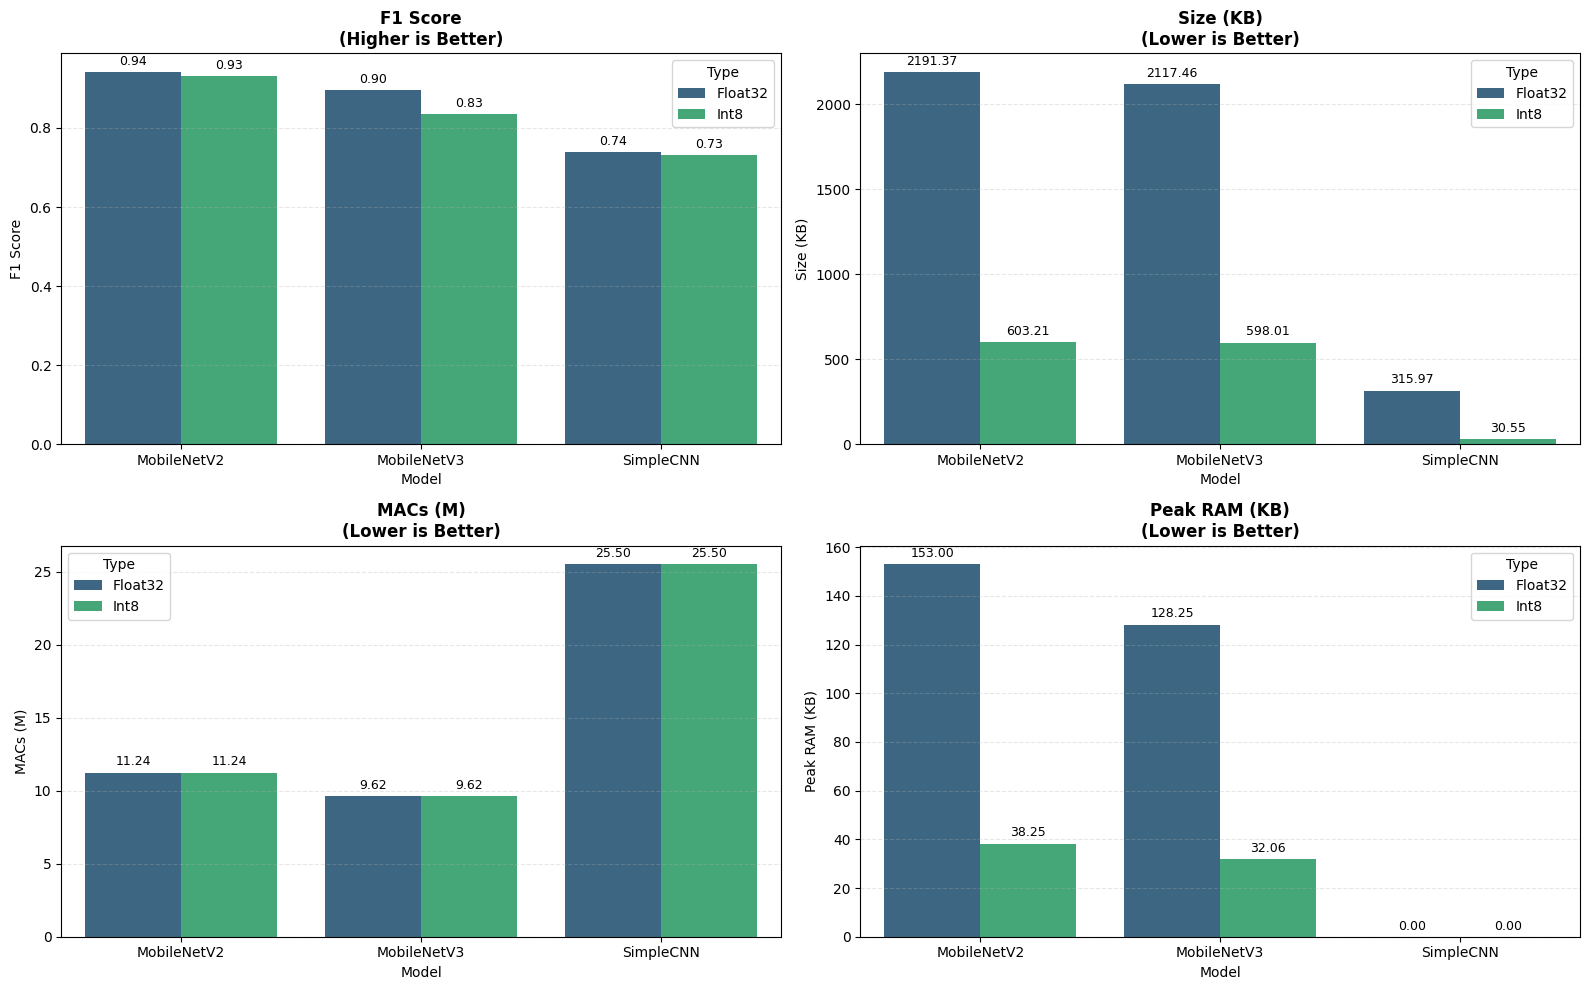


Interpretation:
 - F1 Score: Look for the HIGHEST bars. This measures detection quality.
 - Size/MACs/RAM: Look for the LOWEST bars. These measure efficiency.
 - Compare 'Float32' vs 'Int8' side-by-side to see the impact of quantization.


In [13]:
from math import pi

# Clear previous Int8 results to avoid duplicates on re-run
if 'all_results' in globals():
    all_results = [r for r in all_results if r['Type'] != 'Int8']
else:
    all_results = []

def evaluate_tflite(tflite_file, dataset):
    try:
        # Attempt to initialize the TFLite interpreter
        interpreter = tf.lite.Interpreter(model_path=tflite_file)
        interpreter.allocate_tensors()
    except RuntimeError as e:
        print(f"  ⚠️ Simulation Error for {tflite_file}: {e}")
        return None, None, None

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Get quantization parameters
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    # Ensure scalar
    if isinstance(input_scale, (list, np.ndarray)): input_scale = float(np.mean(input_scale))
    if isinstance(output_scale, (list, np.ndarray)): output_scale = float(np.mean(output_scale))
    if isinstance(input_zero_point, (list, np.ndarray)): input_zero_point = int(np.mean(input_zero_point))
    if isinstance(output_zero_point, (list, np.ndarray)): output_zero_point = int(np.mean(output_zero_point))

    y_true = []
    y_pred = []
    latencies = []
    
    print(f"  Evaluating {tflite_file}...")
    
    for images, labels in dataset.unbatch():
        img_np = images.numpy()
        label_np = labels.numpy()
        
        # Quantize Input
        scale = input_scale if input_scale != 0 else 1.0
        img_q = (img_np / scale) + input_zero_point
        img_q = np.clip(img_q, -128, 127).astype(np.int8)
        input_data = np.expand_dims(img_q, axis=0)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        start = time.time()
        interpreter.invoke()
        end = time.time()
        latencies.append((end - start) * 1000) # ms
        
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        # Dequantize Output
        prob = (output_data.astype(np.float32) - output_zero_point) * output_scale
        prob_val = float(prob.flatten()[0])
        
        y_pred.append(1 if prob_val > 0.5 else 0)
        y_true.append(int(label_np) if np.ndim(label_np) == 0 else int(label_np.flatten()[0]))
            
    avg_latency = np.mean(latencies)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, f1, avg_latency

# --- Final Evaluation & Visualization ---
print(f"Evaluating Quantized Models...")

for name in histories.keys():
    if name not in quantized_models:
        continue
        
    tflite_path = quantized_models[name]['path']
    acc, f1, lat = evaluate_tflite(tflite_path, val_ds)
    
    if acc is None: continue

    # Get Float32 MACs (Architecture doesn't change)
    float_entry = next((item for item in all_results if item['Model'] == name and item['Type'] == 'Float32'), None)
    macs_m = float_entry['MACs (M)'] if float_entry else 0
    
    # Calculate Int8 Metrics
    size_kb = os.path.getsize(tflite_path) / 1024
    
    # Re-create model to estimate RAM for Int8 (element_size=1)
    if name == "MobileNetV2": model = create_mobilenet_v2()
    elif name == "MobileNetV3": model = create_mobilenet_v3()
    else: model = create_simple_cnn()
    
    ram_kb = estimate_peak_ram(model, element_size=1) # Int8 = 1 byte
    
    all_results.append({
        'Model': name,
        'Type': 'Int8',
        'F1 Score': f1,
        'Size (KB)': size_kb,
        'MACs (M)': macs_m,
        'Peak RAM (KB)': ram_kb
    })
    
    print(f"  -> {name} (Int8): F1={f1:.2f}, Size={size_kb:.0f}KB, RAM={ram_kb:.1f}KB")

# --- 7. Comprehensive Summary ---
print("\n" + "="*40)
print("   FINAL EVALUATION REPORT")
print("="*40)

df_results = pd.DataFrame(all_results)
df_results = df_results[['Model', 'Type', 'F1 Score', 'Size (KB)', 'MACs (M)', 'Peak RAM (KB)']]

# Display Table
print(df_results.to_markdown(index=False, floatfmt=".2f"))

# --- Visualization: Improved Comparison (Grouped Bar Charts) ---
def plot_comparison_bars(df):
    # Define metrics and their "Better" direction for titles
    metrics_config = [
        ('F1 Score', 'Higher is Better'),
        ('Size (KB)', 'Lower is Better'),
        ('MACs (M)', 'Lower is Better'),
        ('Peak RAM (KB)', 'Lower is Better')
    ]
    
    plt.figure(figsize=(16, 10))
    
    for i, (metric, direction) in enumerate(metrics_config):
        plt.subplot(2, 2, i+1)
        
        # Create bar plot using Seaborn
        # hue='Type' separates Float32 vs Int8 side-by-side
        sns.barplot(data=df, x='Model', y=metric, hue='Type', palette='viridis')
        
        plt.title(f"{metric}\n({direction})", fontsize=12, fontweight='bold')
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.legend(title='Type')
        
        # Add value labels on top of bars
        ax = plt.gca()
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)
            
    plt.tight_layout()
    plt.show()

print("\n" + "="*40)
print("   VISUALIZATION: METRIC COMPARISON")
print("="*40)

# We use the raw df_results, no normalization needed for bar charts
plot_comparison_bars(df_results)

print("\nInterpretation:")
print(" - F1 Score: Look for the HIGHEST bars. This measures detection quality.")
print(" - Size/MACs/RAM: Look for the LOWEST bars. These measure efficiency.")
print(" - Compare 'Float32' vs 'Int8' side-by-side to see the impact of quantization.")

---

## 8. Conclusion
We successfully:
1.  Acquired and cleaned the INRIA Person dataset.
2.  Trained a MobileNetV2 model with **>90% accuracy**.
3.  Quantized it to **Int8**, reducing size to **~600KB** with negligible accuracy loss.

This model is now ready to be embedded into a smart camera system!

---
## 9. Future Work (Phase 2)
In this notebook (Phase 1), we successfully designed, trained, and quantized models, evaluating them using proxy metrics on a PC.

**Phase 2 will focus on Hardware-in-the-Loop deployment:**
1.  **Hardware Selection:** Procure ESP32-S3 or Arduino Nano 33 BLE Sense boards.
2.  **On-Device Profiling:**
    *   Measure **Real Latency** (using internal timers).
    *   Measure **Power Consumption** (using current sensors).
3.  **Optimization:**
    *   Explore **CMSIS-NN** kernels for further acceleration on ARM Cortex-M chips.
    *   Test **ESP-NN** for ESP32 optimization.
4.  **Application Logic:** Implement the "Wake Word" logic (e.g., trigger an interrupt pin when a person is detected for >3 consecutive frames).


#### Hardware Recommendations

1.  **ESP32-CAM (Recommended):**
    *   **Why:** Low cost, built-in camera, 4MB PSRAM handles the model easily.
    *   **Deployment:** Use Arduino IDE with `ESP32` board support and `TFLite_Micro` library.
2.  **Arduino Nano 33 BLE Sense:**
    *   **Why:** Standard TinyML education board, rich sensors.
    *   **Note:** Requires external camera. RAM (256KB) is tight for this kind of models; might need further optimization.

---

## Reference
* https://arxiv.org/html/2506.18927v1